In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import itertools
import logging
import sys
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Subplots

In [ ]:
def values(model, market, b, fairness, perfect=False):
  n = 3
  L = [i for i in range(1,n+1)]

  p_ij, a_ij, org_q, sur = {}, {}, {}, {}
  total_surplus = 0

  price, sur, access, total_surplus = {}, {}, {}, 0
  for i in L:
    for j in range(1, n+1):
      if i != j:
        org_q[i,j] = model.q[i,j]()
        sur[i,j] = model.q[i,j]() * model.q[i,j]() * model.pi[i]() * b[i,j]/2
        access[i,j] = model.q[i,j]() * model.pi[i]()
        total_surplus += market[i,j] * sur[i,j]
        if fairness == 'Access':
          price[i,j] = b[i,j] * (1-model.q[i,j]())
        else:
          if perfect:
            price[i,j] = model.p()
          else:
            price[i,j] = model.p[i,j]()

  p_origin, a_origin = [], []
  for i in L:
    p_origin.append(sum([price[i,j]*market[i,j] for j in L if i != j])/sum([market[i,j] for j in L if i != j]))
    a_origin.append(sum([access[i,j]*market[i,j] for j in L if i != j])/sum([market[i,j] for j in L if i != j]))

  p_star_trip, a_star_trip = max(price.values()) - min(price.values()), max(access.values())-min(access.values())
  p_star_origin, a_star_origin = max(p_origin) - min(p_origin), max(a_origin)-min(a_origin)

  p_star, a_star = max(price.values())-min(price.values()), max(access.values())-min(access.values())
  star = {'p_star_trip': p_star_trip, 'a_star_trip': a_star_trip, 'p_star_origin': p_star_origin, 'a_star_origin': a_star_origin}

  return model.revenue(), price, access, org_q, star, {'s': sur, 'ts': total_surplus}

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.cbook
import matplotlib.colors as mcolors

def subplot_drawing_n_3(revenue_list, total_surplus_list, surplus_list, price_list, access_list, market=None, criteria='origin'):
  fig, axs = plt.subplots(1, 4, figsize=(16, 3), constrained_layout=True, gridspec_kw={'hspace': 0.5})
  n_iter = len(revenue_list)
  iter_list = [i/(n_iter-1) for i in range(n_iter)] if n_iter != 1 else [0]
  axs[0].plot(iter_list, revenue_list, color='r', label = r'$\mathcal{R}(\alpha)$', linewidth=3.0)
  axs[0].plot(iter_list, total_surplus_list, color='g', label = r'$\mathcal{S}(\alpha)$', linewidth=3.0)
  axs[0].plot(iter_list, [revenue_list[i] + total_surplus_list[i] for i in range(n_iter)], color='b', label = r'$\mathcal{W}(\alpha)$', linewidth=3.0)

  level = 0.8
  c = ['#069AF3', '#0343DF', '#FFA500', '#FF4500', '#15B01A', '#006400']
  index = [(1,2), (1,3), (2,1), (2,3), (3,1), (3,2)]

  if criteria == 'trip':
    for i in range(6):
      axs[1].plot(iter_list, [p[index[i]] for p in price_list], label=r'$p_{%s}$' %str(index[i])[1:-1], linewidth=3.0, color=c[i], alpha=level)
    p_max = max([max([p[idx] for idx in index]) for p in price_list]) + 0.3
    axs[1].set_ylim(-0.3, min(10, p_max))
  else:
    axs[1].plot(iter_list, [(market[1,2] * p[1,2] + p[1,3] * market[1,3])/(market[1,2]+market[1,3]) for p in price_list], label=r'$\bar{p}_1$', linewidth=3.0, color='b', alpha=level)
    axs[1].plot(iter_list, [(market[2,1] * p[2,1] + p[2,3] * market[2,3])/(market[2,1]+market[2,3]) for p in price_list], label=r'$\bar{p}_2$', linewidth=3.0, color='r', alpha=level)
    axs[1].plot(iter_list, [(market[3,1] * p[3,1] + p[3,2] * market[3,2])/(market[3,1]+market[3,2]) for p in price_list], label=r'$\bar{p}_3$', linewidth=3.0, color='g', alpha=level)

  if criteria == 'trip':
    for i in range(6):
      axs[2].plot(iter_list, [a[index[i]] for a in access_list], label=r'$A_{%s}$' %str(index[i])[1:-1], linewidth=3.0, color=c[i], alpha=level)
  else:
    axs[2].plot(iter_list, [(market[1,2] * a[1,2] + a[1,3] * market[1,3])/(market[1,2]+market[1,3]) for a in access_list], label=r'$\bar{A}_1$', linewidth=3.0, color='b', alpha=level)
    axs[2].plot(iter_list, [(market[2,1] * a[2,1] + a[2,3] * market[2,3])/(market[2,1]+market[2,3]) for a in access_list], label=r'$\bar{A}_2$', linewidth=3.0, color='r', alpha=level)
    axs[2].plot(iter_list, [(market[3,1] * a[3,1] + a[3,2] * market[3,2])/(market[3,1]+market[3,2]) for a in access_list], label=r'$\bar{A}_3$', linewidth=3.0, color='g', alpha=level)

  # surplus
  for i in range(6):
    axs[3].plot(iter_list, [s[index[i]] for s in surplus_list], label=r'$\mathcal{S}_{%s}$' %str(index[i])[1:-1], linewidth=3.0, color=c[i], alpha=level)


  for i in range(4):
    axs[i].set_xlim([0, 1])
    axs[i].grid()

  for i in range(4):
    box = axs[i].get_position()
    axs[i].set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    if i in [0]: # 1 row
      axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fancybox=True, shadow=True, ncol=3, prop={"size":10})
    else:
      axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), fancybox=True, shadow=True, ncol=3, prop={"size":10})

    if criteria == 'origin':
      axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fancybox=True, shadow=True, ncol=3, prop={"size":10})
      axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fancybox=True, shadow=True, ncol=3, prop={"size":10})

  for ax in axs.flat:
      ax.set(xlabel=r'$\alpha$')
      ax.xaxis.label.set_fontsize(18) #28

  plt.show()

In [ ]:
def simulator(fairness='Price', criteria='origin', alpha_list = None, K=10, solver='ipopt'):
  # solver = 'ipopt'
  dir_path = '/content/drive/MyDrive/Colab_Notebooks/Fair Fares/Operations_Research/save'

  if fairness == 'Price':
      market = {(1, 1): 0, (1, 2): 9, (1, 3): 10, (2, 1): 5, (2, 2): 0, (2, 3): 2, (3, 1): 7, (3, 2): 1, (3, 3): 0}
      b = {(1, 1): 0, (1, 2): 3, (1, 3): 7, (2, 1): 8, (2, 2): 0, (2, 3): 5, (3, 1): 1, (3, 2): 5, (3, 3): 0}
      K = 10
  else:
    market = {(1, 1): 0, (1, 2): 10, (1, 3): 2, (2, 1): 7, (2, 2): 0, (2, 3): 2, (3, 1): 6, (3, 2): 1, (3, 3): 0}
    b = {(1, 1): 0, (1, 2): 5, (1, 3): 8, (2, 1): 10, (2, 2): 0, (2, 3): 5, (3, 1): 9, (3, 2): 9, (3, 3): 0}
    K = 10

  n = 3
  L = [i for i in range(1,n+1)]
  star = None
  revenue_list, surplus_list, total_surplus_list, p_list, a_list, q_list = [], [], [], [], [], []

  if fairness == 'Access':
    file_path = os.path.join(dir_path, f'vanilla_{solver}_access.pkl')
    #file_path = os.path.join(dir_path, f'vanilla_ipopt_access.pkl')
  else:
    file_path = os.path.join(dir_path, f'vanilla_{solver}_price.pkl')
  with open(file_path, "rb") as f:
    vanilla_model = pickle.load(f)['model']

  revenue, price, access, org_q, _star, sur_dict = values(vanilla_model, market, b, 'Access', perfect=False)
  if solver == 'couenne':
    revenue = revenue * 10/(10+3-1) * (3+3-1)/3
  revenue_list.append(revenue)
  surplus_list.append(sur_dict['s'])
  total_surplus_list.append(sur_dict['ts'])
  p_list.append(price)
  q_list.append(org_q)
  a_list.append(access)

  if fairness == 'Price':
    star = _star['p_star_trip'] if criteria == 'trip' else _star['p_star_origin']
  elif fairness == 'Access':
    star = _star['a_star_trip'] if criteria == 'trip' else _star['a_star_origin']

  #alpha_list = [a/10 for a in range(1,11)] if alpha_list == None else alpha_list
  alpha_list = [0.2, 0.4, 0.6, 0.8, 1]
  print('fair models')
  for a in alpha_list:
    print('alpha = %.1f' %a)
    file_path = os.path.join(dir_path, f'{fairness}_{criteria}_{a}_{solver}.pkl')
    with open(file_path, "rb") as f:
      load_f = pickle.load(f)
      loaded_model = load_f['model']
      if solver == 'couenne':
        print('time_limit', load_f['time_limit'])

    if fairness == 'Access':
      #print(values(loaded_model, market, b, fairness='Access'))
      revenue, price, access, org_q, _star, sur_dict = values(loaded_model, market, b, fairness='Access')
    if fairness == 'Price':
      if a == 1 and criteria == 'trip':
        revenue, price, access, org_q, _star, sur_dict = values(loaded_model, market, b, fairness='Price', perfect = True)
      else:
        revenue, price, access, org_q, _star, sur_dict = values(loaded_model, market, b, fairness='Price')

    revenue_list.append(revenue)
    surplus_list.append(sur_dict['s'])
    total_surplus_list.append(sur_dict['ts'])
    p_list.append(price)
    q_list.append(org_q)
    a_list.append(access)

  subplot_drawing_n_3(revenue_list, total_surplus_list, surplus_list, p_list, a_list, market, criteria=criteria)
  #return revenue_list, total_surplus_list, surplus_list, p_list, a_list, q_list

In [ ]:
def simulator(fairness='Price', criteria='origin', alpha_list = None, K=10, solver='ipopt'):
  # solver = 'ipopt'

  dir_path = '/content/drive/MyDrive/Colab_Notebooks/Fair Fares/Operations_Research/save'

  if fairness == 'Price':
    market = {(1, 1): 0, (1, 2): 9, (1, 3): 10, (2, 1): 5, (2, 2): 0, (2, 3): 2, (3, 1): 7, (3, 2): 1, (3, 3): 0}
    b = {(1, 1): 0, (1, 2): 3, (1, 3): 7, (2, 1): 8, (2, 2): 0, (2, 3): 5, (3, 1): 1, (3, 2): 5, (3, 3): 0}
    K = 10
  else:
    market = {(1, 1): 0, (1, 2): 10, (1, 3): 2, (2, 1): 7, (2, 2): 0, (2, 3): 2, (3, 1): 6, (3, 2): 1, (3, 3): 0}
    b = {(1, 1): 0, (1, 2): 5, (1, 3): 8, (2, 1): 10, (2, 2): 0, (2, 3): 5, (3, 1): 9, (3, 2): 9, (3, 3): 0}
    K = 10

  n = 3
  L = [i for i in range(1,n+1)]
  star = None
  revenue_list, surplus_list, total_surplus_list, p_list, a_list, q_list = [], [], [], [], [], []

  if fairness == 'Price':
    file_path = os.path.join(dir_path, f'vanilla_{solver}_price.pkl')
  else:
    file_path = os.path.join(dir_path, f'vanilla_{solver}_access.pkl')
  with open(file_path, "rb") as f:
    vanilla_model = pickle.load(f)['model']

  revenue, price, access, org_q, _star, sur_dict = values(vanilla_model, market, b, 'Access', perfect=False)
  revenue_list.append(revenue)
  surplus_list.append(sur_dict['s'])
  total_surplus_list.append(sur_dict['ts'])
  p_list.append(price)
  q_list.append(org_q)
  a_list.append(access)

  if fairness == 'Price':
    star = _star['p_star_trip'] if criteria == 'trip' else _star['p_star_origin']
  elif fairness == 'Access':
    star = _star['a_star_trip'] if criteria == 'trip' else _star['a_star_origin']

  #alpha_list = [a/10 for a in range(1,11)] if alpha_list == None else alpha_list
  alpha_list = [0.2, 0.4, 0.6, 0.8, 1]
  print('fair models')
  for a in alpha_list:
    print('alpha = %.1f' %a)
    file_path = os.path.join(dir_path, f'{fairness}_{criteria}_{a}_{solver}.pkl')
    with open(file_path, "rb") as f:
      load_f = pickle.load(f)
      loaded_model = load_f['model']
      if solver == 'couenne':
        print('time_limit', load_f['time_limit'])


    if fairness == 'Access':
      #print(values(loaded_model, market, b, fairness='Access'))
      revenue, price, access, org_q, _star, sur_dict = values(loaded_model, market, b, fairness='Access')
    if fairness == 'Price':
      if a == 1 and criteria == 'trip':
        revenue, price, access, org_q, _star, sur_dict = values(loaded_model, market, b, fairness='Price', perfect = True)
      else:
        revenue, price, access, org_q, _star, sur_dict = values(loaded_model, market, b, fairness='Price')

    revenue_list.append(revenue)
    surplus_list.append(sur_dict['s'])
    total_surplus_list.append(sur_dict['ts'])
    p_list.append(price)
    q_list.append(org_q)
    a_list.append(access)

  subplot_drawing_n_3(revenue_list, total_surplus_list, surplus_list, p_list, a_list, market, criteria=criteria)
  #return revenue_list, total_surplus_list, surplus_list, p_list, a_list, q_list

fair models
alpha = 0.2
alpha = 0.4
alpha = 0.6
alpha = 0.8
alpha = 1.0


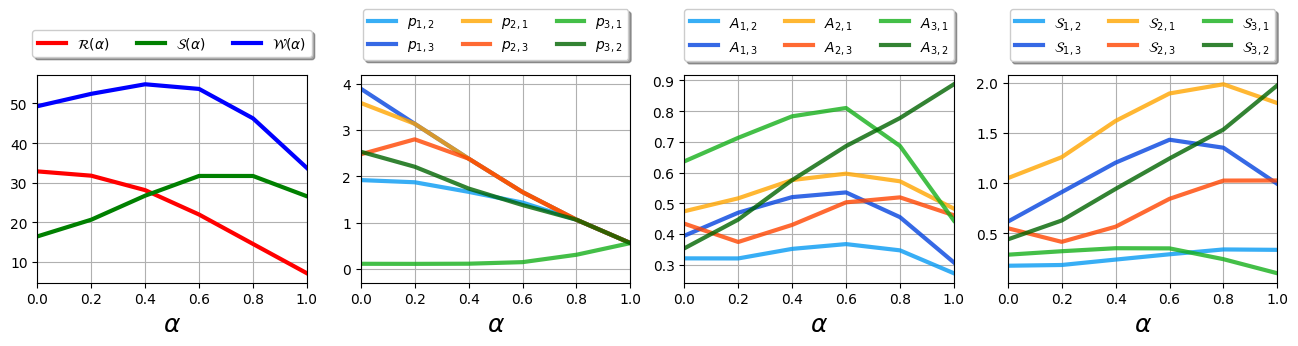

In [ ]:
simulator(fairness='Price', criteria='trip', solver='ipopt')

fair models
alpha = 0.2
time_limit 7200
alpha = 0.4
time_limit 7200
alpha = 0.6
time_limit 7200
alpha = 0.8
time_limit 7200
alpha = 1.0
time_limit 7200


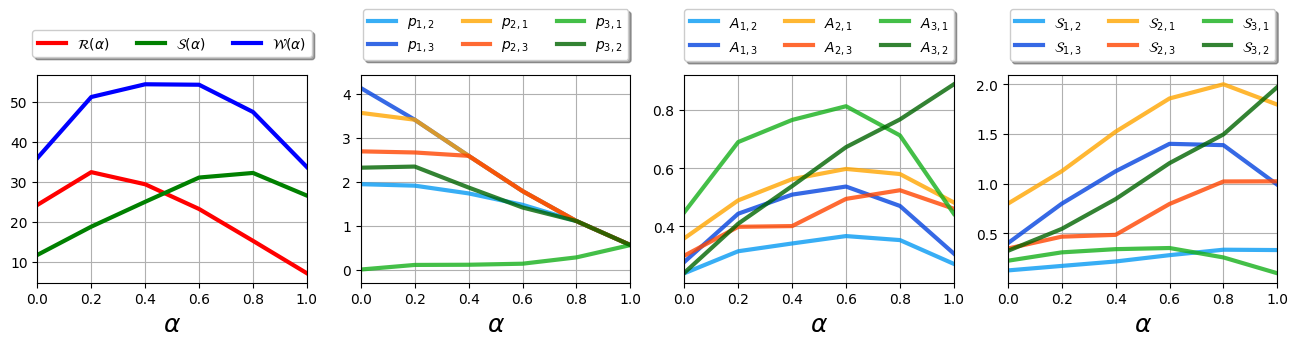

In [ ]:
simulator(fairness='Price', criteria='trip', solver='couenne')

fair models
alpha = 0.2
alpha = 0.4
alpha = 0.6
alpha = 0.8
alpha = 1.0


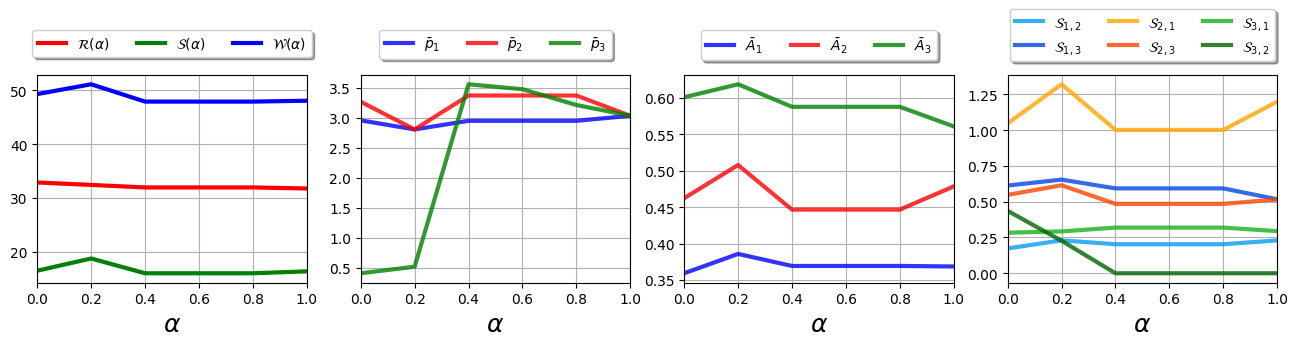

In [ ]:
simulator(fairness='Price', criteria='origin', solver='ipopt')

fair models
alpha = 0.2
time_limit 7200
alpha = 0.4
time_limit 7200
alpha = 0.6
time_limit 7200
alpha = 0.8
time_limit 7200
alpha = 1.0
time_limit 7200


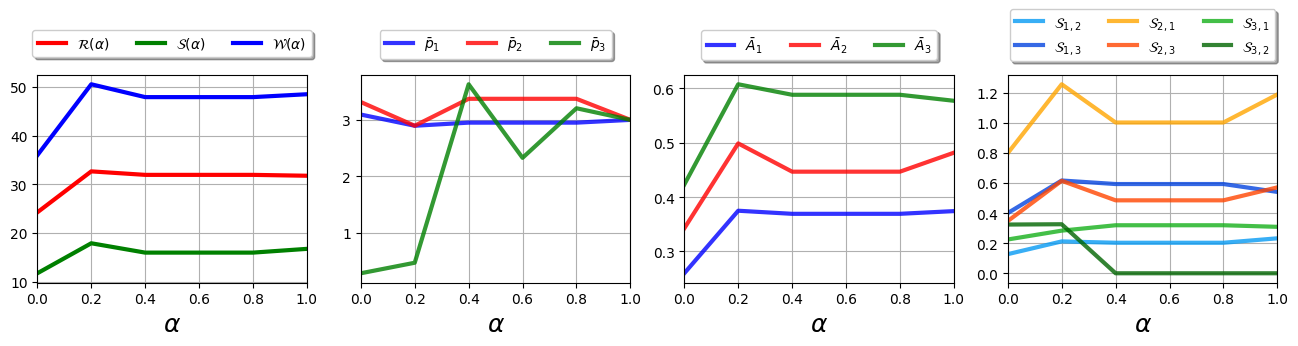

In [ ]:
simulator(fairness='Price', criteria='origin', solver='couenne')

fair models
alpha = 0.2
alpha = 0.4
alpha = 0.6
alpha = 0.8
alpha = 1.0


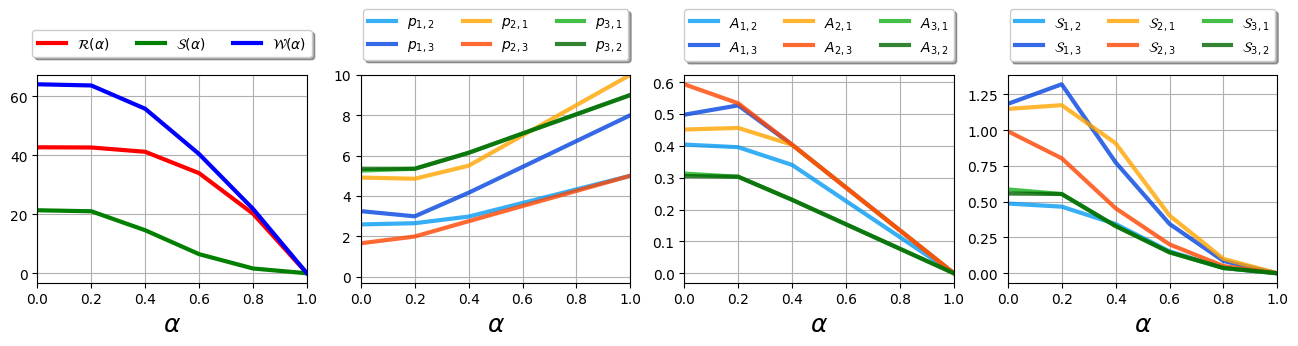

In [ ]:
simulator(fairness='Access', criteria='trip', solver='ipopt')

fair models
alpha = 0.2
time_limit 7200
alpha = 0.4
time_limit 7200
alpha = 0.6
time_limit 7200
alpha = 0.8
time_limit 7200
alpha = 1.0
time_limit 7200


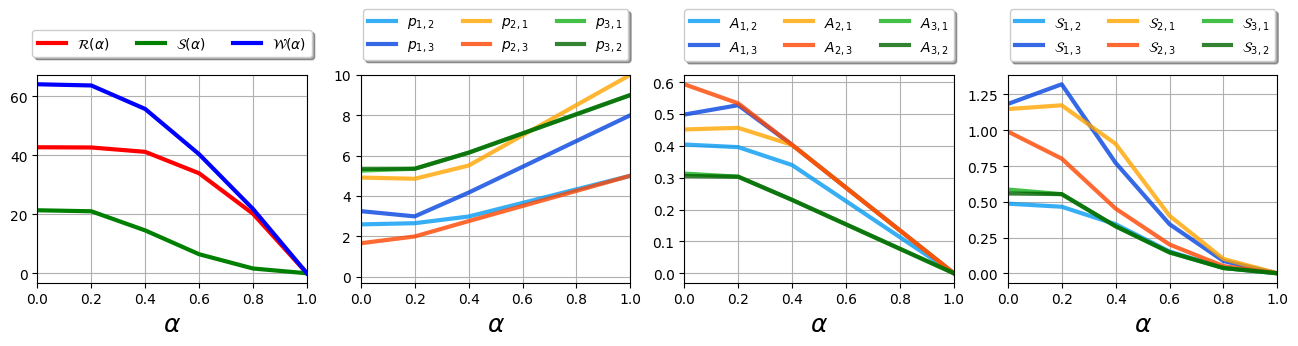

In [ ]:
simulator(fairness='Access', criteria='trip', solver='couenne')

fair models
alpha = 0.2
alpha = 0.4
alpha = 0.6
alpha = 0.8
alpha = 1.0


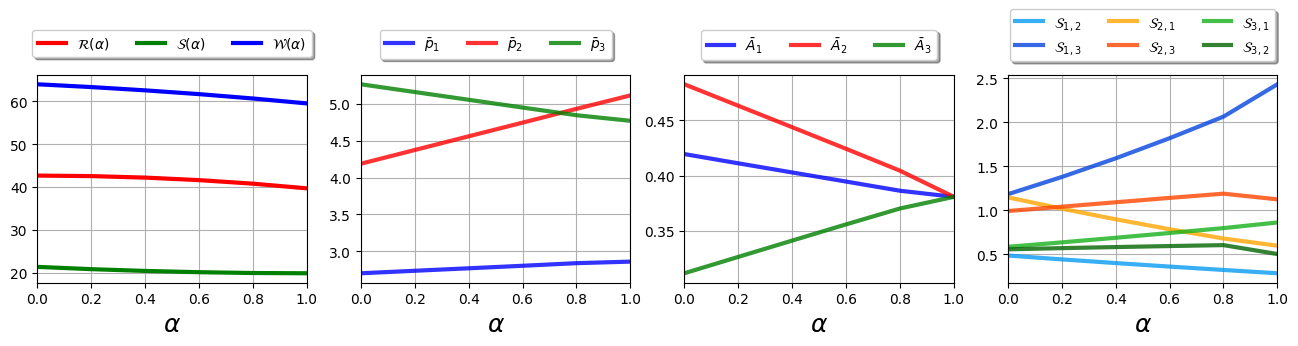

In [ ]:
simulator(fairness='Access', criteria='origin', solver='ipopt')

fair models
alpha = 0.2
time_limit 7200
alpha = 0.4
time_limit 7200
alpha = 0.6
time_limit 7200
alpha = 0.8
time_limit 7200
alpha = 1.0
time_limit 7200


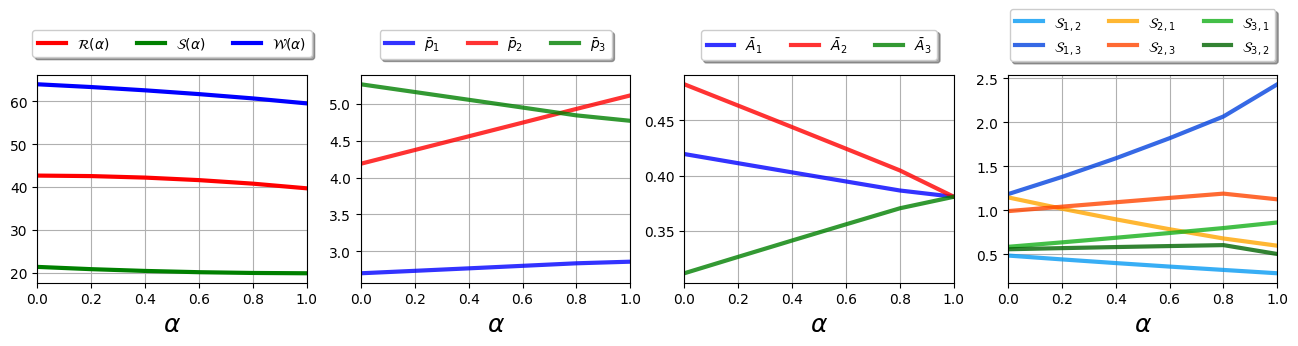

In [ ]:
simulator(fairness='Access', criteria='origin', solver='couenne')